<a href="https://colab.research.google.com/github/toot09/CF_WINGS_POS/blob/master/POS_CF_ONEPERSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source : https://data-science-hi.tistory.com/73

In [ ]:
#한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import numpy as np
import pandas as pd
import math
import operator
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [2]:
# 상품 마스터
items=[]
ms_item={}
with open('ITEM_2114.csv','r',encoding='UTF-8') as f:
  for line in f.readlines():
    items.append(line.strip().split(","))
for i in items[1:]:
  # {item : [company, class4, class5]}
  ms_item[i[0]] = [i[1], i[2], i[3]]
all_item = [i[0] for i in items[1:]]
print(all_item[:2])
print(ms_item)

['간장치킨230G(하림)', '갈릭새우볶음밥450G(롯데푸드)']
{'간장치킨230G(하림)': ['11', '스낵', '고메너겟치킨류'], '갈릭새우볶음밥450G(롯데푸드)': ['8', '레디밀', '비비고냉동밥'], '감자튀김750G(롯데푸드)': ['8', '스낵기타', '스낵기타'], '고구마돈까스800g(대상)': ['4', '까스류', '실속돈까스'], '고구마치즈돈까스2KG(사조)': ['6', '까스류', '실속돈까스'], '고기동그랑땡800G(진주)': ['14', '한식반찬(비비고)', '비비고동그랑땡'], '고르곤졸라사각피자88G(오뚜기)': ['2', '스낵', '고메피자'], '고메고르곤졸라피자300G/냉동(씨제이제일제당)': ['1', '스낵', '고메피자'], '고메고추크런치치킨박스300G(씨제이제일제당)': ['1', '스낵', '고메너겟치킨류'], '고메그릴피자디아볼라300G/냉동(씨제이제일제당)': ['1', '스낵', '고메피자'], '고메그릴피자불고기360G/냉동(씨제이제일제당)': ['1', '스낵', '고메피자'], '고메그릴피자콤비네이션415G/냉동(씨제이제일제당)': ['1', '스낵', '고메피자'], '고메그릴피자포테이토400G/냉동(씨제이제일제당)': ['1', '스낵', '고메피자'], '고메너겟230G_CVS/냉동(씨제이제일제당)': ['1', '스낵', '고메너겟치킨류'], '고메빅크리스피핫도그520G/냉동(씨제이제일제당)': ['1', '스낵', '고메핫도그'], '고메사이드바이츠치즈볼270G/냉동(씨제이제일제당)': ['1', '스낵기타', '스낵기타'], '고메치즈크리스피핫도그425G/냉동(씨제이제일제당)': ['1', '스낵', '고메핫도그'], '고메치킨박스고추크런치600G(씨제이제일제당)': ['1', '스낵', '고메너겟치킨류'], '고메치킨박스스위허니600G(씨제이제일제당)': ['1', '스낵', '고메너겟치킨류'], '고메치킨순살크리스피550G/냉동(씨제이제일제당)': ['1', '스낵

In [3]:
# 매출 마스터
sales=[]
with open('POS_2114.csv','r',encoding='UTF-8') as f:
  for line in f.readlines():
    sales.append(line.strip().split(","))
print(sales[:2])

[['\ufeffADDR', 'ITEM', 'SALE'], ['강원도 강릉시', '고메그릴피자불고기360G/냉동(씨제이제일제당)', '6']]


In [4]:
# 1인 가구 비율
tmp=[]
with open('RT_ONE.csv','r',encoding='UTF-8') as f:
  for line in f.readlines():
    tmp.append(line.strip().split(","))
rtOne={}
for i in tmp[1:]:
  rtOne[i[0]] = float(i[1])
print(rtOne)

{'고양시 덕양구': 0.25117018054214, '고양시 일산동구': 0.26290805455411, '고양시 일산서구': 0.18866716363705, '광주광역시 광산구': 0.27208691125091, '광주광역시 남구': 0.2835011082379, '광주광역시 동구': 0.38482906450272, '광주광역시 북구': 0.31562951522096, '광주광역시 서구': 0.32198044780826, '김제시 고창군': 0.34874759152215, '김제시 무주군': 0.34786803009839, '김제시 부안군': 0.33770197486535, '김제시 순창군': 0.32988089073019, '김제시 완주군': 0.3189087977531, '김제시 임실군': 0.37492764409162, '김제시 장수군': 0.33464945043218, '김제시 진안군': 0.34933078393881, '대구광역시 남구': 0.41259015821312, '대구광역시 달서구': 0.27962935351745, '대구광역시 달성군': 0.23703560174184, '대구광역시 동구': 0.29739989562407, '대구광역시 북구': 0.2910230896221, '대구광역시 서구': 0.12146753097694, '대구광역시 수성구': 0.23792925218092, '대구광역시 중구': 0.24250052443885, '대전광역시 대덕구': 0.31045729242322, '대전광역시 동구': 0.37501949317738, '대전광역시 서구': 0.32746638693604, '대전광역시 유성구': 0.34014655633773, '대전광역시 중구': 0.30515306227908, '부산광역시 강서구': 0.23983178379269, '부산광역시 금정구': 0.33715389318607, '부산광역시 기장군': 0.26529019101785, '부산광역시 남구': 0.2969270346942, '부산광역시 동구': 0

In [5]:
# 지역별, 상품별 판매수량 Dict
def sales_dictionary(ratings):
  s_dict={}
  for i in sales[1:]:
    if i[0] not in s_dict:
      s_dict[i[0]] = {i[1]:float(i[2])}
    else:
      s_dict[i[0]].setdefault(i[1],float(i[2]))
  #{ ADDR : { ITEM : SALE }
  return s_dict

In [6]:
# 코사인 유사도
def cosine_similarity(A,B):
  dot_p = np.dot(A,B)
  A_norms = math.sqrt(sum([i**2 for i in A]))
  B_norms = math.sqrt(sum([i**2 for i in B]))
  AB_norms = A_norms*B_norms
  return dot_p/AB_norms

In [9]:
def get_sameclass_graph(ms_item, target, classDepth, addr, s_dict):
  
  # 조회클래스 계층에 따른 ms_item의 index (4:1 / 5:2)
  classDepth -= 3
  # 타겟 상품명
  nmItem = target[0]
  # 타겟 Class 명
  nmClass = ms_item[nmItem][classDepth]
  
  result = {}

  for item in s_dict[addr].keys():
    if ms_item[nmItem][classDepth]!=nmClass or item==nmItem:
      continue
    result[item] = s_dict[addr][item]
  
  result = sorted(result.items(), key=operator.itemgetter(1), reverse=True)

  item = []
  sale = []
  item.append(nmItem)
  sale.append(target[1])
  for i in result:
    item.append(i[0])
    sale.append(i[1])
  plt.bar(item[:3], sale[:3], color='b')
  plt.xlabel('Item')
  plt.ylabel('Sale')
  plt.show()

In [7]:
# 지역별 판매현황
slDf = pd.DataFrame(np.array(sales[1:]),columns=sales[0])
# 지역별, 상품별 판매수량 { 지역 : {상품 : 판매수량} }
s_dict = sales_dictionary(slDf)

In [8]:
# 사용자기반 필터링 (User Based Filtering - UBF)
def user_based_filtering(sale_dict, addr, k=3):
  
  # 지역의 매출 상품이 존재하지 않으면 return
  #if addr not in sale_dict.keys():
  #  return {}
  
  # 지역의 매출 상품 집합(Set)
  addr_s = set(sale_dict[addr].keys())
  similar_score={}
  
  for other_addr in sale_dict.keys():
    # addr과 other_addr의 공통 매출 상품 교집합(intersection)
    both_s = addr_s.intersection(set(sale_dict[other_addr].keys()))
    # 공통된 매출상품이 1개 이상인 경우만 고려
    if (len(both_s)>=1) and (other_addr in rtOne.keys()):
      # 매출수량과 1인가구 비율 차이 가중값으로 코사인 유사도 도출
      addr_s_sale = [sale_dict[addr][i] for i in both_s]
      addr_other_sale = [sale_dict[other_addr][i] for i in both_s]
      similar_score[other_addr] = cosine_similarity(addr_s_sale, addr_other_sale) - abs(rtOne[addr]-rtOne[other_addr])/10000
  
  #유사도 높은 지역순으로 sort
  neighborhood = sorted(similar_score.items(), key=operator.itemgetter(1), reverse=True)
  print("■■■ 지역의 유사도 현황 ■■■")
  print(neighborhood[:50])

  # 추천을 위한 neighborhood 리스트
  addr_for_recommendation = [i[0] for i in neighborhood]
  # addr에 판매기록이 없는 상품리스트
  no_sale_i = set(all_item) - addr_s

  # 추천결과
  recommendation_of_items = {}
  for item in no_sale_i:
    # 제일제당 상품만 추천 (제조사코드 1)
    if ms_item[item][0]!='1':
      continue
    r=[]
    s=[]
    for addr in addr_for_recommendation:
      if item in sale_dict[addr].keys():
        # 1인가구로 계산된 유사도로 예상 매출수량 반영
        r.append(sale_dict[addr][item]*similar_score[addr])
        s.append(similar_score[addr])
      else:
        continue
    # 판매상품기록이 없는 상품이 다른 지역에도 판매되지 않은경우
    if (len(r)==0):
      continue
    # k보다 작거나 같은 판매기록이 있는경우 사용자끼리의 가중평균을 구함
    elif len(r)<=k:
      recommendation_of_items[item] = sum(r)/sum(s)
    # K보다 많은 판매기록이 있는경우 정확도를 위해 상위 k번째의 지역에 대해서만 평균(가중평균)을 둠
    else:
      recommendation_of_items[item] = sum(r[:k])/sum(s[:k])
  return sorted(recommendation_of_items.items(), key=operator.itemgetter(1), reverse=True)[:1000]

In [15]:
# 사용자 기반 필터링
addr = '서울특별시 강동구'
recommendation_1000 = user_based_filtering(s_dict, addr)
pd.DataFrame(np.array(recommendation_1000[:10]),columns=["상품명","예상판매수량"])

■■■ 지역의 유사도 현황 ■■■
[('서울특별시 강동구', 1.0000000000000002), ('서울특별시 광진구', 0.8490966930593399), ('서울특별시 도봉구', 0.8460534470402556), ('대전광역시 중구', 0.8299307560739856), ('서울특별시 구로구', 0.8243891816158642), ('대전광역시 유성구', 0.8226555948620599), ('서울특별시 영등포구', 0.8211200525889896), ('서울특별시 동대문구', 0.8206497398425655), ('서울특별시 양천구', 0.8186480154149611), ('서울특별시 은평구', 0.8153053904794046), ('부산광역시 부산진구', 0.8152026034713128), ('대구광역시 달서구', 0.8147778470918103), ('서울특별시 중랑구', 0.8127835365211528), ('서울특별시 강남구', 0.8127259771061804), ('대전광역시 동구', 0.8120269953763073), ('광주광역시 북구', 0.8080259486867907), ('부산광역시 연제구', 0.8011072361484959), ('서울특별시 노원구', 0.8009793776723495), ('서울특별시 강서구', 0.7985519497512945), ('서울특별시 서대문구', 0.7977246316296853), ('서울특별시 중구', 0.7976884432464767), ('서울특별시 성북구', 0.7957678868373433), ('서울특별시 성동구', 0.7910668277751813), ('서울특별시 마포구', 0.7875602970233733), ('대전광역시 대덕구', 0.7840716202834549), ('서울특별시 관악구', 0.781735721471468), ('대전광역시 서구', 0.7781147857015861), ('부산광역시 금정구', 0.7745013965740886), ('

,상품명,예상판매수량
0,비비고/도톰동그랑땡425G*2_BC/냉동(씨제이제일제당),22.65611862358508
1,스팸김치볶음밥220G(컵)_CVS/냉동(씨제이제일제당),5.140837877142284
2,비비고닭갈비볶음밥440G/냉동(씨제이제일제당),4.343855371667668
3,CJ/맛있는돈까스600G/냉동(씨제이제일제당),4.0075902269168475
4,고메치킨박스고추크런치600G(씨제이제일제당),3.6704986861557525
5,CJ밀당의고수김말이850G/냉동(씨제이제일제당),3.661397153222734
6,고메너겟230G_CVS/냉동(씨제이제일제당),3.4955142540758053
7,고메사이드바이츠치즈볼270G/냉동(씨제이제일제당),3.3374703520864326
8,고메고추크런치치킨박스300G(씨제이제일제당),3.3345378139934745
9,고메하프피자베이컨포테이토310G/냉동(씨제이제일제당),3.021612308084659


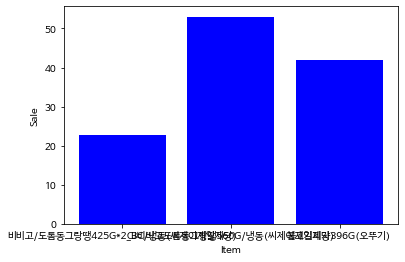

In [14]:
# 아이템마스터, 타겟아이템 (추천아이템중), 계층(4,5), 주소, s_dict)
result = get_sameclass_graph(ms_item, recommendation_1000[0], 5, addr, s_dict)

In [16]:
# 아이템 기반 필터링 (Item Based Filtering - IBF)
def item_based_filtering(sale_dict, addr, k=3):
  # 임시 (addr 별 매출이 있는 상품 list)
  #tmp = [list(sale_dict[i].keys()) for i in list(sale_dict.keys())]
  # 매출이 발생하지 않은 상품들 체크를 위한 list(데이터는 모든 매출이 발생한 상품)
  #no_sale_i = list(j for i in tmp for j in i)
  
  # 매출이 발생하지 않은 상품들 (ujone)
  no_sale_i = set(all_item) - sale_dict[addr].keys()
  # addr에 매출 발생된 상품
  sale_i = [i for i in sale_dict[addr].keys()]

  # 매출 발생되지 않은 상품에 대한 dict
  c_s = {}

  # j:매출발생된 상품 / i:매출발생하지 않은 상품(알아볼 상품)
  for i in no_sale_i:
    # 제일제당 상품만 추천 (상품코드 : 1)
    if ms_item[i][0]!='1':
      continue
    c_s[i] = {}
    for j in sale_i:
      p_i = []
      p_j = []
      for p in list(sale_dict.keys()):
        if j in sale_dict[p].keys() and i in sale_dict[p].keys() and p in rtOne.keys():
          p_i.append(sale_dict[p][i] - abs(rtOne[addr]-rtOne[p])/10000)
          p_j.append(sale_dict[p][j] - abs(rtOne[addr]-rtOne[p])/10000)
      if len(p_i)>0:
        c = cosine_similarity(p_i, p_j)
        c_s[i].setdefault(j,c)
        #{ 매출발생하지 않은 상품 : {매출발생된 상품 : 코사인유사도} }
  
  print("■■■ 상품별 유사도 현황 ■■■")
  for i in list(c_s.keys())[:2]:
    tmp = sorted(c_s[i].items(), key=operator.itemgetter(1), reverse=True)
    print("예상 상품 : ",i," 매출발생 상품 : ",tmp[0]," 유사도 : ",tmp[1])
  
  # 결과
  result = {}

  # 매출 발생하지 않은 상품에 대한 코사인 유사도 계산
  for i in list(c_s.keys()):
    sum_sim_rating=[]
    sum_sim=[]
    # 코사인 유사도가 높은순으로 정렬
    k_i_j = sorted(c_s[i].items(), key=operator.itemgetter(1), reverse=True)

    for j in k_i_j:
      # 코사인 유사도
      sum_sim.append(j[1])
      # 코사인 유사도와 매출발생된 상품간의 예측계산
      sum_sim_rating.append( j[1]*sale_dict[addr][j[0]] )

    if len(sum_sim)>0:
      # 매출 발생하지 않은 상품에 대한 예측 매출수량
      result[i] = sum(sum_sim_rating)/sum(sum_sim)

  return sorted(result.items(), key=operator.itemgetter(1), reverse=True)

In [18]:
# 아이템 기반 필터링
addr = '대구광역시 서구'
recommendation_1000 = item_based_filtering(s_dict, addr)
pd.DataFrame(np.array(recommendation_1000[:10]),columns=["상품명","예상판매수량"])


■■■ 상품별 유사도 현황 ■■■
예상 상품 :  스팸김치볶음밥220G(컵)_CVS/냉동(씨제이제일제당)  매출발생 상품 :  ('대림선마늘숙성떡갈비(스테이크형)480G(사조)', 1.0)  유사도 :  ('대림선알찬동그랑땡1KG(사조)', 1.0)
예상 상품 :  신비비고언양식바싹불고기460G+92G_HP/냉동(씨제이제일제당)  매출발생 상품 :  ('고메사이드바이츠치즈볼270G/냉동(씨제이제일제당)', 1.0)  유사도 :  ('고메치킨박스스위허니600G(씨제이제일제당)', 1.0)


,상품명,예상판매수량
0,B)쉐프솔루션/새우볶음밥300G*5/냉동(씨제이제일제당),5.348061419543314
1,신비비고언양식바싹불고기460G+92G_HP/냉동(씨제이제일제당),5.330491983725859
2,B)CS햄야채볶음밥300G/냉동(씨제이제일제당),5.288461538461538
3,cj)고메베이커리애플턴오버(씨제이제일제당),5.288461538461538
4,B)쉐프솔루션/낙지볶음밥300G*5/냉동(씨제이제일제당),5.27536231884058
5,프레시안/스팸볶음밥660G(씨제이제일제당),5.225562264497253
6,스팸볶음밥220G(컵)_CVS/냉동(씨제이제일제당),5.1832549448196445
7,프레시안/도톰동그랑땡515G*2/냉동(씨제이제일제당),5.163043478260869
8,고메고추크런치치킨박스300G(씨제이제일제당),5.125526007725854
9,고메너겟230G_CVS/냉동(씨제이제일제당),5.106895522672268


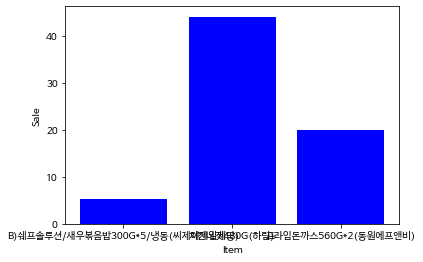

In [19]:
# 아이템마스터, 타겟아이템 (추천아이템중), 계층(4,5), 주소, s_dict)
result = get_sameclass_graph(ms_item, recommendation_1000[0], 5, addr, s_dict)